# Практическая работа №3

# Выполнил студент группы ББМО-02-23 Карпейкин Владислав Анатольевич

## Шаги выполнения

### Шаг 1. Загрузка обученной модели и данных MNIST

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в формат one-hot
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('/content/mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9752 - loss: 0.0817
Test accuracy on clean images: 0.9778000116348267


###Шаг 2: Установка Foolbox и запуск CW-атаки

In [4]:
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.2 MB/s eta 0:00:00


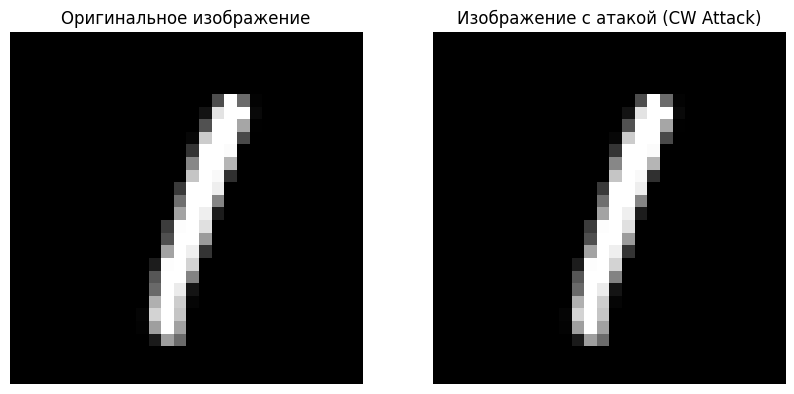

In [6]:
import torch
import torch.nn as nn
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))
# Выбор изображения для атаки (например, первое изображение из тестового набора)
image = tf.convert_to_tensor(test_images[5], dtype=tf.float32)[None, ...]
label = np.argmax(test_labels[0])
label_tensor = tf.convert_to_tensor(label, dtype=tf.int64)
# Создание атаки Carlini-Wagner
attack = fb.attacks.L2CarliniWagnerAttack(steps=3)
# Выполнение атаки
tf.config.list_physical_devices('GPU')
adversarial_image = attack(fmodel, image, label_tensor[None], epsilons=0.1)

# Вывод результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Изображение с атакой (CW Attack)")
plt.imshow(adversarial_image[0][0].numpy(), cmap="gray")
plt.axis('off')
plt.show()

###Шаг 3: Оценка модели на противоречивых примерах

In [7]:
adversarial_images = []
batch_size = 32  # Установите размер пакета

# Обработка изображений пакетами
for i in range(0, len(test_images) // 10, batch_size):
    # Создаем пакет изображений и меток
    batch_images = tf.convert_to_tensor(test_images[i:i + batch_size], dtype=tf.float32)
    batch_labels = np.argmax(test_labels[i:i + batch_size], axis=1)
    batch_labels = tf.convert_to_tensor(batch_labels, dtype=tf.int64)

    # Убедитесь, что метки имеют правильную форму (размерность (32,))
    # Атака на пакет изображений
    advs, _, success = attack(fmodel, batch_images, batch_labels, epsilons=0.1)
    adversarial_images.append(advs)

# Конвертация списка в массив с правильной формой
adversarial_images = tf.concat(adversarial_images, axis=0)

# Убедитесь, что test_labels имеют соответствующее количество меток
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[:len(adversarial_images)])
print(f'Accuracy on adversarial examples (CW attack): {adversarial_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0927 - loss: 2.3688 
Accuracy on adversarial examples (CW attack): 0.083984375


#Вывод:
Значение точности 0.083984375 указывает на то, что модель демонстрирует плохую производительность на адверсариальных примерах, что свидетельствует о высокой уязвимости. Это означает, что модель может быть легко обманута атаками, что представляет серьезную проблему в реальных сценариях.